In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam

In [4]:
env = gym.make('CartPole-v1')
env

<TimeLimit<CartPoleEnv<CartPole-v1>>>

In [5]:
env.reset()

array([0.00302826, 0.04281733, 0.04880896, 0.048722  ], dtype=float32)

In [6]:
env.step(0)

(array([ 0.0038846 , -0.15296929,  0.0497834 ,  0.35639632], dtype=float32),
 1.0,
 False,
 {})

In [7]:
env.action_space.n

2

In [8]:
env.reward_range

(-inf, inf)

In [9]:
env._max_episode_steps

500

In [10]:
for i in range(0,1000):
    #env.render()
    a = np.random.randint(0,2)
    print(env.step(a))

(array([ 0.00082522, -0.3487624 ,  0.05691133,  0.66435236], dtype=float32), 1.0, False, {})
(array([-0.00615003, -0.15447636,  0.07019837,  0.39011806], dtype=float32), 1.0, False, {})
(array([-0.00923956, -0.35052076,  0.07800074,  0.7040818 ], dtype=float32), 1.0, False, {})
(array([-0.01624997, -0.15656142,  0.09208237,  0.43693635], dtype=float32), 1.0, False, {})
(array([-0.0193812 ,  0.03714468,  0.1008211 ,  0.17464216], dtype=float32), 1.0, False, {})
(array([-0.01863831,  0.23069002,  0.10431394, -0.08461036], dtype=float32), 1.0, False, {})
(array([-0.01402451,  0.424174  ,  0.10262173, -0.34264603], dtype=float32), 1.0, False, {})
(array([-0.00554103,  0.22775318,  0.09576882, -0.01944699], dtype=float32), 1.0, False, {})
(array([-0.00098596,  0.03139756,  0.09537987,  0.3018498 ], dtype=float32), 1.0, False, {})
(array([-3.5801364e-04, -1.6494523e-01,  1.0141687e-01,  6.2302452e-01],
      dtype=float32), 1.0, False, {})
(array([-0.00365692,  0.02862536,  0.11387736,  0.36

/Users/indra25/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [11]:
class Actor:
    def __init__(self,state_shape,total_actions):
        self.input_shape = state_shape
        self.output_shape = total_actions
        self.model = self.theta_NN()
        self.step_size = 0.001
        
    def step(self,state):
        action_probs,_ = self.predict_policy_actions(state) #generate probabilities from Actor N/W
        action = np.random.choice(self.output_shape, 1, p=action_probs.flatten())[0] #generate actions using 
                                                                        #the above probability distribution
        return action
    
    def theta_NN(self):
        
        inputs = keras.Input(shape=(self.input_shape,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(self.output_shape, activation="softmax")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())

        return model
    
    def learn(self,samples):
        
        X = []
        y = []
        
        for state,action,delta in samples:
            
            state_f = self.preprocess(state)
            action_probs = self.model.predict(state_f).flatten()
            encoded_action = np.zeros(self.output_shape)
            encoded_action[action] = 1

            gradient = encoded_action - action_probs
            gradient_with_advantage = self.step_size * gradient * delta + action_probs
            gradient_with_advantage = gradient_with_advantage.reshape((1,self.output_shape))

            X.append([state_f])
            y.append(gradient_with_advantage)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape))
        y = np.reshape(y,(y.shape[0],self.output_shape))
        
        self.model.train_on_batch(X, y)

    def predict_policy_actions(self,state):
        state_f = self.preprocess(state)
        action_probabilities = self.model.predict([state_f],verbose=0)
        optimal_action = np.argmax(action_probabilities)
        
        return action_probabilities, optimal_action
    
    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape))
    
    def test_step(self,state):
        _,action = self.predict_policy_actions(state)
        return action

In [15]:
actor = Actor(4,2)
state = env.reset()
actor.step(state)

1

In [16]:
class Critic:
    def __init__(self,state_shape,total_actions):
        self.input_shape = state_shape
        self.model = self.w_NN()
    
    def w_NN(self):
        
        inputs = keras.Input(shape=(self.input_shape,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(1, activation="linear")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())
        
        return model
    
    def learn(self,samples):
        X = []
        y = []
        
        for state,action,delta in samples:
            state_f = self.preprocess(state)
            state_value = delta#np.array(delta)
            state_value_f = state_value.reshape((1,1))
            X.append([state_f])
            y.append(state_value_f)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape))
        y = np.reshape(y,(y.shape[0],1))
        
        self.model.train_on_batch(X, y)

    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape))
    
    def predict_VF_values(self,state):
        state_f = self.preprocess(state)
        state_value = self.model.predict([state_f],verbose=0).flatten()[0]
        return state_value
    

In [17]:
critic = Critic(4,2)
state = env.reset()
critic.predict_VF_values(state)

0.012958541

In [27]:
def main(no_of_episodes = 100,freq_time_steps=5):
    env = gym.make('CartPole-v1')
    env.reset()
    state_shape = env.observation_space.low.shape[0]
    action_shape = env.action_space.n
    
    actor = Actor(state_shape,action_shape)
    critic = Critic(state_shape,action_shape)
    
    episodes = no_of_episodes
    discount_factor = 0.99
    
    overall_episode_rewards = np.array([])
    samples  = []
    window = 10
    
    #train
    print("Training for {} episodes".format(episodes))
    for ep in range(1,episodes+1):
        state = env.reset()
        #env.render()
        
        episode_reward = 0
        time_step = 1
        train_freq_ts = freq_time_steps
        
        while True:
            
            action = actor.step(state)
            next_state, reward, done, info = env.step(action)
            reward = -100*(abs(next_state[2]) - abs(state[2])) 

            #calculate delta
            state_value = critic.predict_VF_values(state)
            next_state_value = critic.predict_VF_values(next_state)
    
            if done:
                next_state_value = 0
            delta = reward + discount_factor * next_state_value - state_value
            samples.append((state,action,delta))
            
            #train every train_freq_ts timesteps
            if(time_step % train_freq_ts == 0):
                critic.learn(samples) #update weights/actor-model-params
                actor.learn(samples)  #update theta/actor-model-params
                samples = []

            state = next_state
            episode_reward += reward
            time_step += 1
            
            if done or time_step > env._max_episode_steps:
                break
                    
        print("Episode:{}/{},return: {}".format(ep,episodes,episode_reward))
        overall_episode_rewards = np.append(overall_episode_rewards,episode_reward)
        
        if(ep > window+2):
            if np.mean(overall_episode_rewards[-window:]) > 470:
                print("==============>>>>> Converged at {} Episode <<<<<==============".format(ep))
                break
    
    plt.plot(overall_episode_rewards)
    plt.show()
    #plt.plot(overall_time_steps)

    #test
    print("Testing for 10 episodes")
    test_episode_rewards = np.array([])
    for ep in range(1,11):
        state = env.reset()
        test_rewards = 0
        time_step = 1
        
        while True:
            
            action = actor.test_step(state)
            next_state, reward, done, info = env.step(action)
            
            state = next_state
            test_rewards += reward
            time_step += 1
            
            
            if done or time_step > env._max_episode_steps:
                break
        print("Episode:{},return: {}".format(ep,test_rewards))
        test_episode_rewards = np.append(test_episode_rewards,test_rewards)
    plt.plot(test_episode_rewards)
    plt.show()

Training for 10 episodes
1/1 [==============================] - 0s 12ms/step
Episode:1/10,return: -20.17008848488331
1/1 [==============================] - 0s 10ms/step
Episode:2/10,return: -16.847912967205048
1/1 [==============================] - 0s 19ms/step
Episode:3/10,return: -19.909163936972618
1/1 [==============================] - 0s 12ms/step
Episode:4/10,return: -22.29972817003727
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
Episode:5/10,return: -18.41992549598217
1/1 [==============================] - 0s 12ms/step
Episode:6/10,return: -19.792263209819794
1/1 [==============================] - 0s 10ms/step
Episode:7/10,return: -21.257394924759865
1/1 [==============================] - 0s 14ms/step
Episode:8/10,return: -16.472962126135826
1/1 [==============================] - 0s 16ms/step
Episode:9/10,return: -23.80830328911543
1/1 [==============================] - 0s 20ms/step
Episode:10/10,return: -17.045290023088455


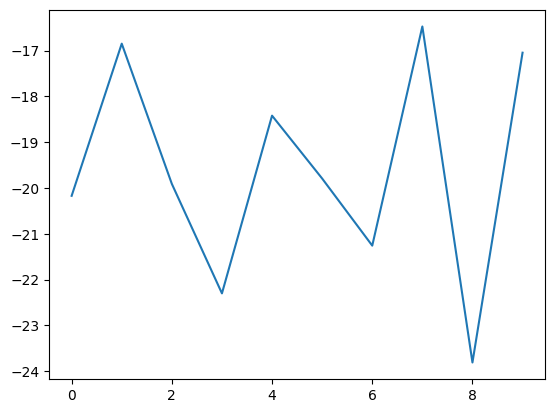

Testing for 10 episodes
Episode:1,return: 43.0
Episode:2,return: 52.0
Episode:3,return: 52.0
Episode:4,return: 51.0
Episode:5,return: 48.0
Episode:6,return: 49.0
Episode:7,return: 48.0
Episode:8,return: 51.0
Episode:9,return: 50.0
Episode:10,return: 54.0


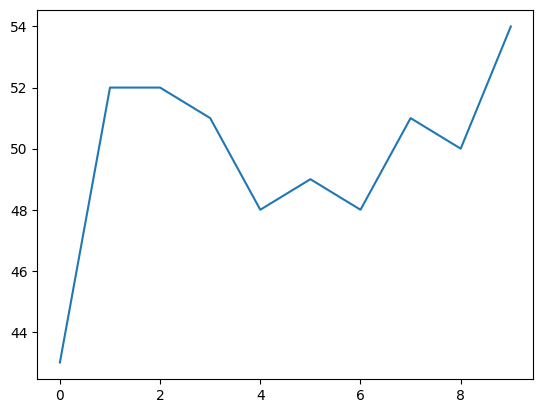

In [28]:
main(10,1)

Training for 100 episodes
1/1 [==============================] - 0s 12ms/step
Episode:1/100,return: -16.820350289344788
1/1 [==============================] - 0s 13ms/step
Episode:2/100,return: -21.011357102543116
1/1 [==============================] - 0s 13ms/step
Episode:3/100,return: -20.511577650904655
1/1 [==============================] - 0s 16ms/step
Episode:4/100,return: -19.0187755972147
1/1 [==============================] - 0s 12ms/step
Episode:5/100,return: -16.36970154941082
1/1 [==============================] - 0s 13ms/step
Episode:6/100,return: -22.501987544819713
1/1 [==============================] - 0s 13ms/step
Episode:7/100,return: -24.996917904354632


1/1 [==============================] - 0s 10ms/step
Episode:8/100,return: -17.6869910210371
1/1 [==============================] - 0s 20ms/step
Episode:9/100,return: -20.016508642584085
1/1 [==============================] - 0s 15ms/step
Episode:10/100,return: -20.15380635857582
1/1 [==============================] - 0s 10ms/step
Episode:11/100,return: -20.841920003294945
1/1 [==============================] - 0s 32ms/step
Episode:12/100,return: -19.99792931601405
1/1 [==============================] - 0s 10ms/step
Episode:13/100,return: -22.751790122129023
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 24ms/step
Episode:14/100,return: -16.951659694314003
1/1 [==============================] - 0s 21ms/step
Episode:15/100,return: -18.998355977237225
1/1 [==============================] - 0s 12ms/step
Episode:16/100,return: -17.915194085799158
1/1 [==============================] - 0s 12ms/step
Episode:17/100,return: -20.415077777579427
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step
Episode:18/100,return: -16.796819120645523
1/1 [==============================] - 0s 16ms/step
Episode:19/100,return: -20.936868502758443
1/1 [==============================] - 0s 13ms/step
Episode:20/100,return: -18.667929247021675
1/1 [==============================] - 0s 14ms/step
Episode:21/100,return: -21.16065044538118
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step
Episode:22/100,return: -17.717279866337776
1/1 [==============================] - 0s 28ms/step
Episode:23/100,return: -20.288946945220232
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Episode:24/100,return: -20.45692461542785
1/1 [==============================] - 0s 14ms/step
Episode:25/100,return: -16.32468698080629
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 20ms/step
Episode:26/100,return: -19.326655380427837
1/1 [==============================] - 0s 16ms/step
Episode:27/100,return: -16.819343820679933
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 42ms/step
Episode:28/100,return: -20.630828524008393
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
Episode:29/100,return: -3.71877666329965
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step
Episode:30/100,return: -17.88076967932284
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 17ms/step
Episode:31/100,return: -17.159019759856164
1/1 [==============================] - 0s 12ms/step
Episode:32/100,return: -16.93020798265934
1/1 [==============================] - 0s 13ms/step
Episode:33/100,return: -18.218334764242172
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 17ms/step
Episode:34/100,return: -8.288627886213362
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 13ms/step
Episode:35/100,return: -5.308121419511735
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:36/100,return: -1.7484332958701998
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 19ms/step
Episode:37/100,return: -7.470735051902011
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 18ms/step
Episode:38/100,return: 0.1828053209464997
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 23ms/step
Episode:39/100,return: 2.3003240872640163
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step
Episode:40/100,return: 1.223229024617467
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step
Episode:41/100,return: -3.1600255344528705
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
Episode:42/100,return: -0.2606341033242643
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 10ms/step
Episode:43/100,return: 3.445593878859654
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 17ms/step
Episode:44/100,return: 0.3586442267987877
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Episode:45/100,return: -0.04291065488359891
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step
Episode:46/100,return: -0.5513824959052727
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step
Episode:47/100,return: -0.22381218732334673
1/1 [==============================] - 0s 61ms/step


2022-11-22 22:04:28.909728: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 25ms/step
Episode:48/100,return: 0.13908355904277414
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


2022-11-22 22:08:40.823947: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 36ms/step
Episode:49/100,return: -1.1236866310355254
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 43ms/step


2022-11-22 22:11:57.636234: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 38ms/step
Episode:50/100,return: 3.772532722177857
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 26ms/step


2022-11-22 22:14:47.422382: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 23ms/step
Episode:51/100,return: 4.168274693074636
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step
Episode:52/100,return: 4.169422939594369
1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 62ms/step


2022-11-22 22:22:07.368452: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 32ms/step


2022-11-22 22:22:59.529807: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 31ms/step
Episode:53/100,return: 4.733002130524255
1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 25ms/step


2022-11-22 22:24:20.929921: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step
Episode:54/100,return: 0.8006828458746895
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 37ms/step


2022-11-22 22:28:35.267025: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 43ms/step
Episode:55/100,return: 3.974574433232192
1/1 [==============================] - 0s 63ms/step


2022-11-22 22:30:34.445350: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 54ms/step
Episode:56/100,return: -0.235788754071109
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step
Episode:57/100,return: 3.4632324997801334
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


2022-11-22 22:40:06.878989: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 27ms/step
Episode:58/100,return: 2.511122409487143
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 22ms/step
Episode:59/100,return: 0.6452843153965659
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 28ms/step


2022-11-22 22:45:38.358476: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 59ms/step
Episode:60/100,return: 2.044477828894742
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 84ms/step
Episode:61/100,return: 2.2401943162549287
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 33ms/step


2022-11-22 22:54:21.158706: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 64ms/step
Episode:62/100,return: 1.3263853878015652
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step
Episode:63/100,return: 2.0431347882549744
1/1 [==============================] - 0s 27ms/step


2022-11-22 22:58:31.374071: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


2022-11-22 23:01:15.008345: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 55ms/step


2022-11-22 23:01:29.260386: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 35ms/step
Episode:64/100,return: 2.349782909732312
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


2022-11-22 23:03:07.762574: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 25ms/step


2022-11-22 23:04:42.360738: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
Episode:65/100,return: 2.441525610629469
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 51ms/step
Episode:66/100,return: 0.3447086797677912
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step
Episode:67/100,return: 0.44091239105910063
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 31ms/step
Episode:68/100,return: 4.489928251132369
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step
Episode:69/100,return: 1.5550509924651124
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 23ms/step


2022-11-22 23:17:45.557427: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
Episode:70/100,return: 2.257559765712358
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
Episode:71/100,return: 4.084028978832066
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Episode:72/100,return: 4.436251329025254
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:73/100,return: 0.8309498865855858
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:74/100,return: 0.5295286740874872
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:75/100,return: 1.4311282226117328
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:76/100,return: 0.21746543643530458
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:77/100,return: 2.8125099794124253
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:78/100,return: 1.8164640227041673
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:79/100,return: 0.7082661635649856
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:80/100,return: 0.9369351962959627
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
Episode:81/100,return: 3.6614533280953765
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:82/100,return: 0.23012279852991924
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:83/100,return: 3.66541223047534
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:84/100,return: -0.03974281426053494
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:85/100,return: -4.157937609124929
1/1 [==============================] - 0s 12ms/step
Episode:86/100,return: -20.429730007890612
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:87/100,return: 3.04253721551504
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:88/100,return: 1.6654846986057237
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:89/100,return: 0.670889945467934
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:90/100,return: 1.319935091305524
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:91/100,return: 2.0862885226961225
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:92/100,return: 1.9745825833524577
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:93/100,return: 0.7783112836477812
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:94/100,return: 3.6361961982038338
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:95/100,return: 2.888203240581788
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
Episode:96/100,return: 1.9780396687565371
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:97/100,return: -0.23726488288957626
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:98/100,return: 1.7201976908836514
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
Episode:99/100,return: 0.9805208974285051
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:100/100,return: 0.345082234707661


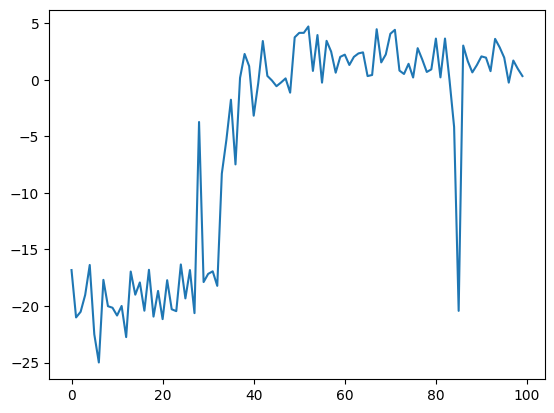

Testing for 10 episodes
Episode:1,return: 500.0
Episode:2,return: 500.0
Episode:3,return: 500.0
Episode:4,return: 500.0
Episode:5,return: 500.0
Episode:6,return: 500.0
Episode:7,return: 500.0
Episode:8,return: 500.0
Episode:9,return: 500.0
Episode:10,return: 500.0


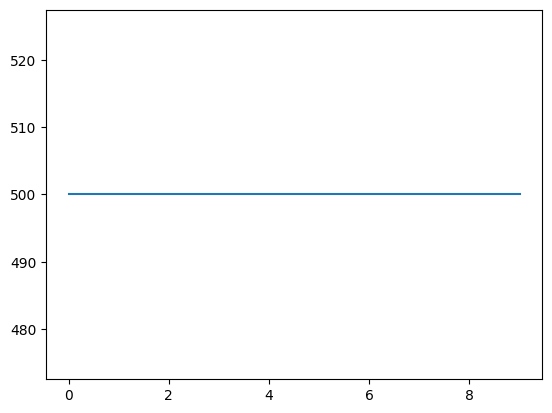

In [29]:
main(100,1)

In [ ]:
main(100,2)

In [ ]:
main(300,1)

In [ ]:
main(300,2)

In [ ]:
main(500,3)

In [ ]:
main(1000,1)

In [ ]:
main(1000,3)

In [ ]:
main(3000,2)

In [ ]:
10 consecutive steps

In [ ]:
0. cartpole 300 check -
1. hyper params - 
2. bipedal walker -- dont
3. i just have to save the model at that point right 
4. negative rewards ?? - NR